In [71]:
from pathlib import Path
import numpy as np
import pandas as pd
import math
from numba import jit,njit
import time
from matplotlib import pyplot as plt
from matplotlib.image import NonUniformImage
import yaml
import matplotlib
from random import sample
from scipy import signal
import pickle
from matplotlib import colors

# import user files
import src.decorators
from src.DataHandler import FilamentSeries, CrosslinkerSeries
from src.CalcCondensationFilaments import condensed_via_xlinks_and_mobility

# plt.rc('text', usetex=True)
# plt.rc('font', family='sans-serif')
# plt.rc('xtick', labelsize='large')
# plt.rc('ytick', labelsize='large')

simpath = Path('/Volumes/WorkSSD/Confinement_paper/Fig34/P1_PF4_X4_w1_p1_k1')

### Load Sim

In [72]:
fastpath_f = simpath / 'Fdata.pickle'
fastpath_x = simpath / 'Xdata.pickle'
if Path.exists(fastpath_f) and Path.exists(fastpath_x):
    print('Loading pickled files')
    with open(fastpath_f, "rb") as fp:
        FData = pickle.load(fp)
    with open(fastpath_x, "rb") as fp:
        XData = pickle.load(fp)
else:
    raise Exception('pickled files not found')

labels, ratio = condensed_via_xlinks_and_mobility(XData, FData, save=False, write2vtk=False)

Loading pickled files
Finished 'calc_num_xlink_filament' in 0.7595 secs
Finished 'calc_mobility' in 0.1860 secs
Condensed Fraction = 0.30 +- 0.001


### Functions

#### 1. Self VanHove

In [43]:
# @src.decorators.timer
def calc_vanhove_self_lag(pos, lagtime, bins):
    """Compute the self part of the van Hove correlation (histogram of displacements).
    The van Hove correlation function is simply a histogram of particle
    displacements. It is useful for detecting physical heterogeneity
    (or tracking errors).
    Parameters
    ----------
    pos : Numpy Array 3D
        dimensions are 3 x N x T
        must be unfolded trajectories
    lagtime : integer interval of frames
        Compare the correlation function at this lagtime.
    bins : integer or sequence
        Specify a number of equally spaced bins, or explicitly specifiy a
        sequence of bin edges. See np.histogram docs.
    Returns
    -------
    vh : Tuple
        Bin-values, and their respective probabilities
    """

    # Create shifted array (by lag)
    pos_lag = np.roll(pos, lagtime, axis=2)
#     pos_lag[:,:,,:lagtime] = np.nan
    
    # Self part of displacements
    disp = np.linalg.norm((pos-pos_lag)[:,:,lagtime:], axis=0).flatten()
    
    # histogram
    counts = np.histogram(disp, bins=bins)[0]
    
    # calc prob density
    pdf = counts / ( np.sum( counts* (bins[1]-bins[0]) ))
    return pdf

@src.decorators.timer
def VanHoveSelf(pos, bins):
    """Compute the self part of the van Hove correlation (histogram of displacements).
    The van Hove correlation function is simply a histogram of particle
    displacements. It is useful for detecting physical heterogeneity
    (or tracking errors).
    Parameters
    ----------
    pos : Numpy Array 3D
        dimensions are 3 x N x T
        must be unfolded trajectories
    bins : integer or sequence
        Specify a number of equally spaced bins, or explicitly specifiy a
        sequence of bin edges. See np.histogram docs.
    """

    # Create lags array
    lags = np.arange(pos.shape[-1])
    
    # Initialize van hove image
    vhove = np.zeros((pos.shape[-1],len(bins)-1))
    
    for jlag,lag in enumerate(lags):
        vhove[jlag,:] = calc_vanhove_self_lag(pos, lag, bins)
    return vhove

#### Test

N condensed = 457
Finished 'VanHoveSelf' in 4.8150 secs


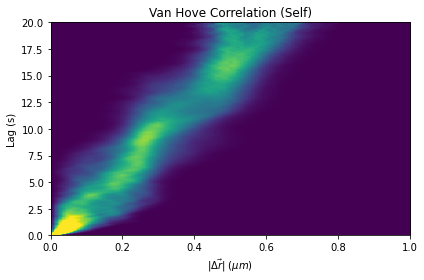

In [76]:
pos = FData.unfold_trajectories('plus')
N = 400
dt = 0.05

# Bins
bins = np.linspace(0,1,100)

# Van Hove on Condensed
idx = np.sum(labels[:,-1*N:], axis=1) == 0
print('N condensed = {0}'.format(np.sum(idx)))
vhove = VanHoveSelf( pos[:,idx,-1*N:], bins)

# Plot
fig,ax = plt.subplots()
ax.imshow(vhove,  vmax=np.max( vhove[vhove<=np.median(vhove[1:20,:10])]),
         aspect='auto', origin='lower', extent=[bins[0],bins[-1],0,N*dt])
ax.set(ylabel='Lag (s)', xlabel=r'$|\Delta \vec{r}|$ $(\mu m)$')
ax.set(title='Van Hove Correlation (Self)')
plt.tight_layout()
plt.savefig('./vhove_self_test.pdf')

In [49]:
vhove[:5,:5]

array([[49.5       ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.61315327,  2.78390861,  3.63772142,  3.11971263,  2.22889918],
       [ 0.31375   ,  1.5471875 ,  2.71140625,  2.9175    ,  2.585625  ],
       [ 0.19740386,  1.11485284,  2.1031285 ,  2.49385309,  2.44799635],
       [ 0.15326934,  0.80943893,  1.62345541,  2.21111944,  2.34876194]])

In [ ]:
@njit
def roll_row(a, lag):
    b = np.roll(a, lag*np.shape(a)[1])
    return b
@njit

def roll_col(a, lag):
    b = np.transpose(a,(1,0))
    c = np.roll(b, lag*np.shape(b)[1])
    return np.transpose(c,(1,0))

In [20]:
@decorators.timer
@njit
def vanhove_distinct_njit(pos, lagtime, bins, box_size):
    
    counts = np.zeros( np.shape(bins)[0]-1)
    nfil = np.shape( pos)[0]
    
    # Create shifted array (by lag in time)
    pos1 = roll_col(pos, lagtime)
    pos1[:,:lagtime] = np.nan
    
    # Loop over filaments
    for jfil in np.arange(1,nfil):
        
        # Create shifted array (by filament number)
        poss = roll_row(pos1, jfil)
        poss[:,:lagtime] = np.nan        
        vals = (poss-pos)[:,lagtime:].flatten()
        # Apply periodic boundary condition
        hw = box_size/2.0
        vals[ vals < -hw] += 2*hw
        vals[ vals > hw] -= 2*hw
        
        counts +=np.histogram(vals, bins=bins)[0]
        
    # calc prob density
    pdf = counts / ( np.sum( counts* (bins[1]-bins[0]) ))
    
    return pdf

@decorators.timer
def vanhove_self_nd(pos, lagtime, bins, box_size):
    """Compute the self part of the van Hove correlation (histogram of displacements).
    The van Hove correlation function is simply a histogram of particle
    displacements. It is useful for detecting physical heterogeneity
    (or tracking errors).
    Parameters
    ----------
    pos : Numpy Array
        x or (or!) y positions, one column per particle, indexed by frame
    lagtime : integer interval of frames
        Compare the correlation function at this lagtime.
    bins : integer or sequence
        Specify a number of equally spaced bins, or explicitly specifiy a
        sequence of bin edges. See np.histogram docs.
    Returns
    -------
    vh : Tuple
        Bin-values, and their respective probabilities
    """

    # Create shifted array (by lag)
    poss = np.roll(pos, lagtime, axis=2)
    poss[:,:,:lagtime] = np.nan
    
    # Self part of displacements
    disp = (poss-pos)[:,:,lagtime:]
    for jdim in np.arange(pos.shape[1]):
        
        hw = box_size[jdim]/2.0    
        # Apply periodic boundary condition
        disp_j = disp[:,jdim,:]
        disp_j[ disp_j <= -hw] += 2.0*hw
        disp_j[ disp_j >= hw] -= 2.0*hw
        disp[:,jdim,:] = disp_j
    
    # ND displacements
    disp = np.reshape( np.linalg.norm(disp, axis=1), -1 )
    
    # histogram
    counts = np.histogram(disp, bins=bins)[0]
    
    # calc prob density
    pdf = counts / ( np.sum( counts* (bins[1]-bins[0]) ))
    
    return pdf

@decorators.timer
def vanhove_distinct_nd(pos, lagtime, bins, box_size):
    
    counts = np.zeros( bins.shape[0]-1)    
    
    # Loop over filaments
    for jfil in np.arange(1,pos.shape[0]):
        
        # Create shifted array (by lag in time and in filament number)
        poss = np.roll(pos, (jfil,0,lagtime), (0,1,2))
        disp = (poss-pos)[:,:, lagtime:]
        
        for jdim in np.arange(pos.shape[1]):
            hw = box_size[jdim]/2.0    
            # Apply periodic boundary condition
            disp_j = disp[:,jdim,:]
            disp_j[ disp_j <= -hw] += 2.0*hw
            disp_j[ disp_j >= hw] -= 2.0*hw
            disp[:,jdim,:] = disp_j

        # ND displacements
        vals = np.reshape( np.linalg.norm(disp, axis=1), -1 )
        counts +=np.histogram(vals, bins=bins)[0]
        
    # calc prob density
    pdf = counts / ( np.sum( counts* (bins[1]-bins[0]) ))
    
    return pdf

@decorators.timer
def vanhove_distinct(pos, lagtime, bins, box_size):
    
    counts = np.zeros( bins.shape[0]-1)
    
    # Loop over filaments
    for jfil in np.arange(1,pos.shape[0]):
        
        # Create shifted array (by lag in time and in filament number)
        poss = np.roll(pos, (jfil,lagtime), (0,1))
#         poss[:,:lagtime] = np.nan
        vals = np.reshape( (poss-pos)[:,lagtime:],-1)
        # Apply periodic boundary condition
        hw = box_size/2.0
        vals[ vals < -hw] += 2.0*hw
        vals[ vals > hw] -= 2.0*hw
        
        counts +=np.histogram(np.absolute(vals), bins=bins)[0]
        
    # calc prob density
    pdf = counts / ( np.sum( counts* (bins[1]-bins[0]) ))
    
    return pdf

### Testing : Distinct ND

* Create Sample random data
* Test function

In [ ]:
dat = centers[1:100,:,:]
bins = np.linspace(-1.0,1.0,1000)
lags = [0,5,50]

fig,ax = plt.subplots()
for idx, lag in enumerate( lags):
    vh = vanhove_distinct(dat[:,-1,:], lag, bins, box_size[-1])
    ax.plot( bins[:-1], vh, label='Lag={0}'.format(lag))

ax.set(title='Van Hove Correlation (distinct)', xlabel=r'$\Delta x (\mu m)$',
       ylabel='Probability of displacement')
plt.legend()
plt.tight_layout()
plt.savefig("/Users/saadjansari/Desktop/pf16_D1_VHdistinct.pdf")

Finished 'vanhove_self' in 0.0044 secs
Finished 'vanhove_self' in 0.0045 secs
Finished 'vanhove_self' in 0.0044 secs
Finished 'vanhove_self' in 0.0041 secs


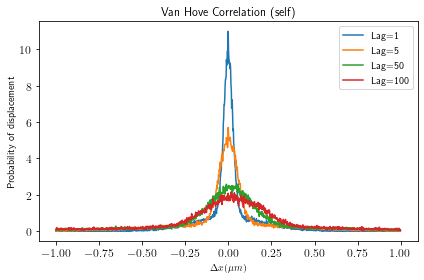

In [31]:
dat = centers[1:100,:,:]
bins = np.linspace(-1.0,1.0,1000)
lags = [1,5,50,100]

fig,ax = plt.subplots()
for idx, lag in enumerate( lags):
    vh = vanhove_self(dat[:,-1,:], lag, bins, box_size[-1])
    ax.plot( bins[:-1], vh, label='Lag={0}'.format(lag))

ax.set(title='Van Hove Correlation (self)', xlabel=r'$\Delta x (\mu m)$',
       ylabel='Probability of displacement')
plt.legend()
plt.tight_layout()
plt.savefig("/Users/saadjansari/Desktop/pf16_D1_VHself.pdf")

### Testing : Distinct 1D

* Create Sample random data
* Test function

Finished 'vanhove_distinct_nd' in 0.1345 secs


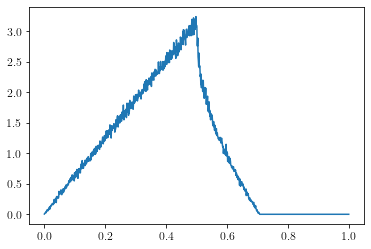

In [32]:
dat = np.random.uniform(size=(100,2, 100))
box_size = [1.0,1.0]
bins = np.linspace(0,1.0,1000)

pdf = vanhove_distinct_nd(dat,0, bins, box_size)
plt.plot( bins[:-1], pdf)


Finished 'vanhove_distinct' in 13.1790 secs


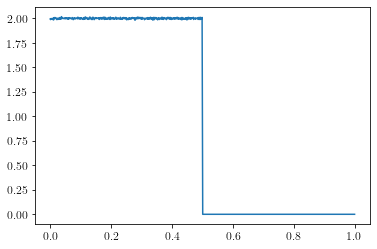

In [18]:
dat = np.random.uniform(size=(1000,100))
# dat[:,0] = np.linspace(0,1,100)
box_size = 1.0
# dat[:,1] = np.linspace(0,1,1000)
bins = np.linspace(0,1.0,1000)

pdf = vanhove_distinct(dat,0, bins, box_size)
plt.plot( bins[:-1], pdf)


In [221]:
from numba import prange
@njit(parallel=True)
def prod(a,b):
    return a**2 + b**2

@decorators.timer
@njit
def prod_n(a,b,n):
    c = np.zeros_like(a)
    for idx in np.arange(n):
        c += prod(a,b)
    return c

@decorators.timer
@njit
def prod_n_parallel(a,b,n):
    c = np.zeros_like(a)
    for idx in np.arange(n):
        c += prod(a,b)
    return c

In [224]:
a = np.random.rand(10000000)
c = prod_n(a,a,10)

Finished 'prod_n' in 0.3136 secs


Count = 10 Hi 4


In [2]:
from platform import python_version
print(python_version())

3.9.5


In [29]:
pdf[-1]

0.0